Regression Problem : input samples with features and output are contineous median price values  

Step 1: load data 

In [1]:
from keras.datasets import boston_housing 

Using TensorFlow backend.


In [3]:
(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

In [6]:
train_targets[0:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

2) Preparing the data: we do normalization for this data

In [7]:
# we done noramlization by using the (feature-mean(feature))/s.d(features)
mean = train_data.mean(axis=0) # each column mean 

In [8]:
mean

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [9]:
train_data-=mean
std = test_data.std(axis=0)
std

array([5.34668449e+00, 2.14669193e+01, 7.04933605e+00, 2.97367664e-01,
       1.09473981e-01, 6.69031503e-01, 2.88923144e+01, 2.36827738e+00,
       8.72901449e+00, 1.76518774e+02, 2.01682561e+00, 7.87494364e+01,
       6.66249874e+00])

In [10]:
train_data/=std

In [11]:
test_data-=mean
test_data/=std

In [12]:
max(train_data[:][0])

1.2514765221073398

In [13]:
train_data.shape[1]

13

3) Building Network 

In [26]:
# as dataset is small so to mitigate ovefitting we have small 
# network and few hidden units 
# in order to use again and again the samll networks we can 
# make a function 
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',
                     input_shape=(13,)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

As in this case the dataset is small so it is preferable to use k-fold cross validation (not suitable to use validation dataset)

In [28]:
import numpy as np
k=4 
num_val_samples = len(train_data)//k
num_epochs =100 # (25*4=100)
all_scores = []


In [30]:
# 4-fold cross validation 
for i in range(k):
    print('processing fold #',i)
    val_data = train_data[i*num_val_samples: 
                          (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:
                                (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model = build_model()
    model.fit(partial_train_data,partial_train_targets,
             epochs=num_epochs,batch_size=1,verbose=0)
    # train the model on silent mode by verbose=0
    val_mse,val_mae = model.evaluate(val_data,val_targets
                                     ,verbose=0)
    all_scores.append(val_mae)

    
    

processing fold # 0
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


In [31]:
all_scores

[2.0551440786607196,
 2.2148941153346904,
 2.9266067188565095,
 2.1823522537061484]

In [32]:
np.mean(all_scores)

2.344749291639517

Analysis : On avearge we get the 2.34K variation in the results or mae while the range of houses median price is 10K to 50K , so the average of all the validation score is a good representer of error 

Next we carry the experimentation for 500 epochs & saving the log at each fold.

In [36]:
num_epochs = 500
all_mae_histories =[]

# 4-fold cross validation 
for i in range(k):
    print('processing fold #',i)
    val_data = train_data[i*num_val_samples: 
                          (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:
                                (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model = build_model()
    
    # saving the log at each fold 
    history  = model.fit(partial_train_data,
                         partial_train_targets,
                         validation_data=(val_data,val_targets),
                         epochs=num_epochs,batch_size=1,verbose=0)
    # train the model on silent mode by verbose=0
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)   

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [40]:
len(all_mae_histories)

4

In [42]:
type(all_mae_histories)

list

In [43]:
all_m = np.array(all_mae_histories)

In [47]:
len(all_m[0])

500

In [48]:
type(all_m)

numpy.ndarray

In [65]:
# buiding the history of successive mean K-fold validation 
# scores 
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) 
                       for i in range(num_epochs)]

In [52]:
len(average_mae_history)

500

In [53]:
average_mae_history[0]

4.554925281222504

Plotting the validation score 

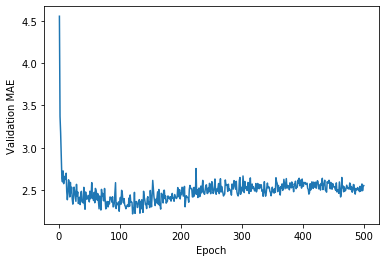

In [67]:
epoch_axis = [i for i in range(1,len(average_mae_history)+1)]

import matplotlib.pyplot as plt

plt.plot(epoch_axis,average_mae_history)
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.show()

In [60]:
epoch_axis

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

Smooth the curve by ommiting the first 10 datapoints 

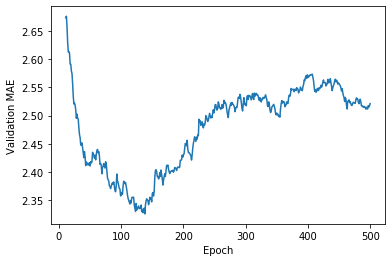

In [71]:
def smooth_curve(points,factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor
                                   +point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history  = smooth_curve(average_mae_history[10:])

plt.plot(epoch_axis[10:],smooth_mae_history)
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.show()

It can be seen from the plot that after 80 epochs the valiadtion MAE is not improving and started overfitting.

So, after analyzing the parameters we are ready to train the model on overall data and test it on the remaining data 

Training Final Model

In [73]:
model = build_model()

model.fit(train_data,train_targets,epochs=80,batch_size=16,
         verbose=0)
test_mse_score,test_mae_score = model.evaluate(test_data
                                               ,test_targets)

102/102 [==============================] - 0s 2ms/step


In [74]:
test_mae_score

2.646236157884785

In [75]:
test_mse_score

16.203601463168276

Here is the final score we have

Regression Example Summary: 
* MSE (mean squred error) is the common loss for regression where biary_crossentropy or categorical_crossentropy (classification)
* MAE (mean absolute error) is the evaluation metrics in place of accuracy (classification)
* Each feature in the input data is normalize if have different sclaes
* if the dataset is small, so k-fold validation is a great way to reliably evaluate the model
* when the dataset is small so use small network noramlly two hidden layers with few hidden units to avoid overfitting 

<---------------------------------- End ------------------------------------->